# EDA: 東北3県 クマ目撃データ × JAXA衛星データ（偏相関分析含む）

## 目的
- 東北3県（秋田、岩手、福島）の熊目撃データをJAXA衛星データと統合
- 時系列相関分析により、衛星指標（NDVI, GSMaP, LST）と目撃件数の関係を把握
- **偏相関分析により季節性の交絡を除去し、衛星データの真の予測力を評価**
- 空間分析により、目撃地点の地形・植生・土地被覆特性を把握
- 機械学習モデル構築への示唆を導出

In [1]:
# Cell 1: Setup imports
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
from pathlib import Path
from scipy import stats
from config import BBOX, JAXA_DIR, SIGHTINGS_CSV, DATE_START, DATE_END

# Set up matplotlib for Japanese text
plt.rcParams['font.family'] = ['Hiragino Sans', 'IPAGothic', 'Noto Sans CJK JP', 'DejaVu Sans']
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print(f"Config loaded:")
print(f"  BBOX: {BBOX}")
print(f"  JAXA_DIR: {JAXA_DIR}")
print(f"  SIGHTINGS_CSV: {SIGHTINGS_CSV}")
print(f"  DATE_START: {DATE_START}, DATE_END: {DATE_END}")

Config loaded:
  BBOX: [139.2, 36.8, 142.1, 40.5]
  JAXA_DIR: /Users/naoya.yasuda/Downloads/CU_JAXA/notebooks/../data/raw/jaxa
  SIGHTINGS_CSV: /Users/naoya.yasuda/Downloads/CU_JAXA/notebooks/../data/raw/sightings/tohoku_sightings.csv
  DATE_START: 2022-04-01T00:00:00, DATE_END: 2025-12-31T00:00:00


## 1. 目撃データの基本統計

In [2]:
# Cell 3: Load sightings data
print(f"Loading sightings from: {SIGHTINGS_CSV}")

try:
    df_sightings = pd.read_csv(SIGHTINGS_CSV, encoding='utf-8-sig')
    df_sightings['date'] = pd.to_datetime(df_sightings['date'])
    df_sightings = df_sightings.sort_values('date').reset_index(drop=True)
    
    print(f"\n=== 目撃データ基本統計 ===")
    print(f"総件数: {len(df_sightings)}")
    print(f"日付範囲: {df_sightings['date'].min()} ～ {df_sightings['date'].max()}")
    print(f"緯度範囲: {df_sightings['lat'].min():.2f} ～ {df_sightings['lat'].max():.2f}")
    print(f"経度範囲: {df_sightings['lon'].min():.2f} ～ {df_sightings['lon'].max():.2f}")
    
    print(f"\n=== 県別内訳 ===")
    print(df_sightings['prefecture'].value_counts())
    
    print(f"\n=== 目撃タイプ内訳 ===")
    print(df_sightings['type'].value_counts())
    
    print(f"\n=== 先頭5行 ===")
    print(df_sightings.head())
    
except Exception as e:
    print(f"Error loading sightings: {e}")
    import traceback; traceback.print_exc()
    df_sightings = pd.DataFrame()

Loading sightings from: /Users/naoya.yasuda/Downloads/CU_JAXA/notebooks/../data/raw/sightings/tohoku_sightings.csv

=== 目撃データ基本統計 ===
総件数: 19889
日付範囲: 2010-06-29 14:30:00 ～ 2026-01-31 23:08:00
緯度範囲: 38.90 ～ 40.50
経度範囲: 139.70 ～ 140.98

=== 県別内訳 ===
prefecture
秋田    19889
Name: count, dtype: int64

=== 目撃タイプ内訳 ===
type
目撃         18819
痕跡(その他)      483
痕跡(食害)       439
人身被害         148
Name: count, dtype: int64

=== 先頭5行 ===
           sighting_id                date        lat         lon type  \
0  akita_kumadas_19889 2010-06-29 14:30:00  39.518743  140.237499   目撃   
1  akita_kumadas_19888 2020-04-29 08:00:00  39.515508  140.237914   目撃   
2  akita_kumadas_19887 2020-05-07 08:00:00  39.515662  140.237894   目撃   
3  akita_kumadas_19886 2020-06-18 17:00:00  39.516445  140.241049   目撃   
4  akita_kumadas_19885 2021-04-13 14:00:00  39.515791  140.237234   目撃   

          source prefecture municipality  \
0  akita_kumadas         秋田          秋田市   
1  akita_kumadas         秋田          秋田

findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


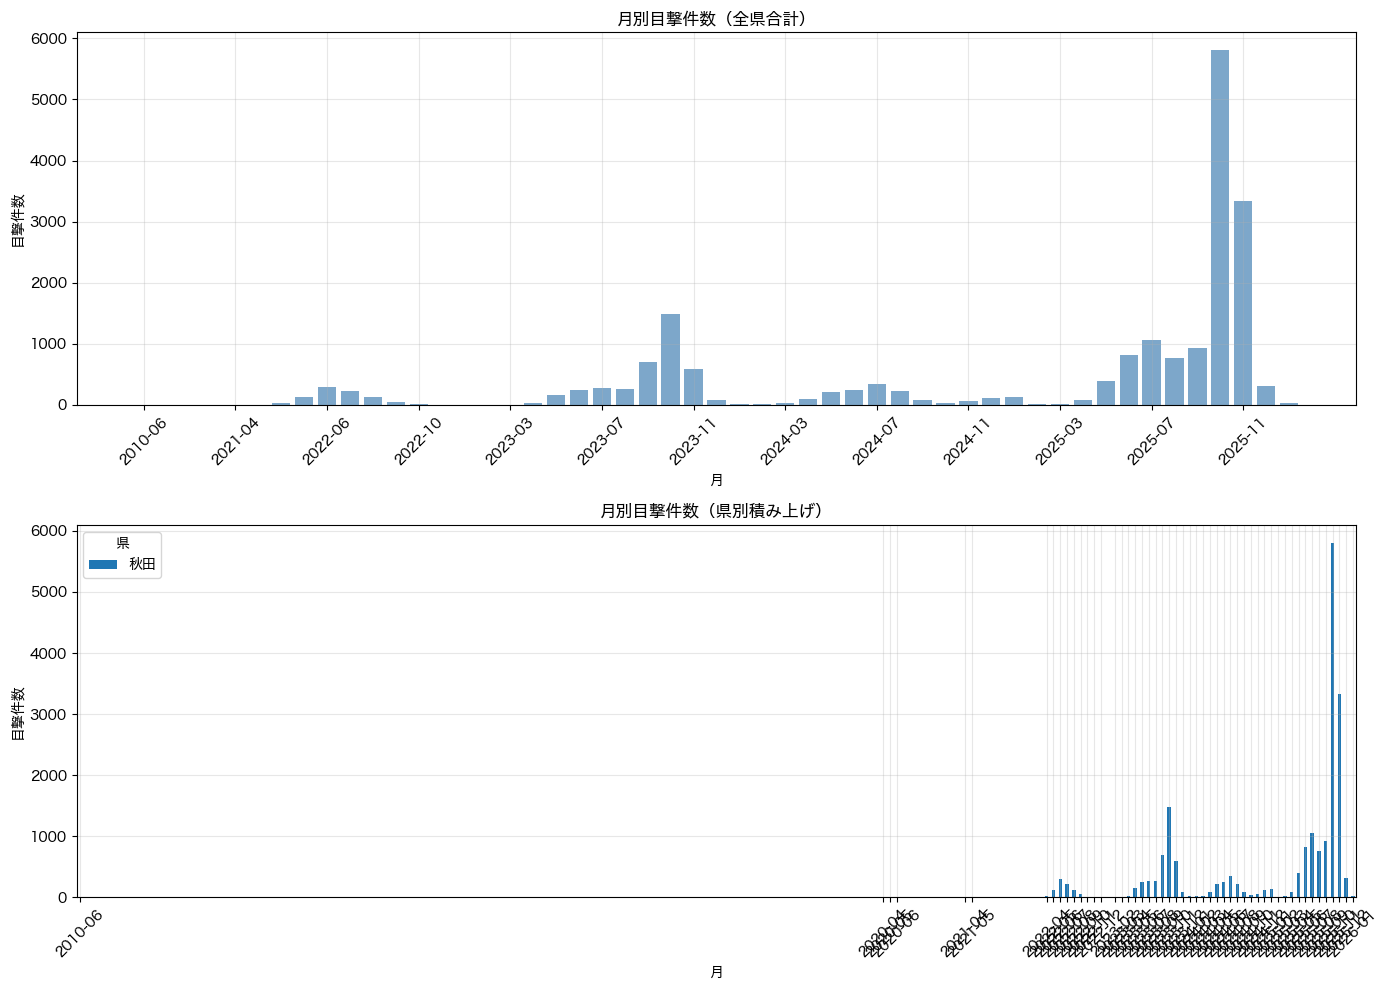

月別目撃件数統計:
  平均: 389.98, 中央値: 89, 最大: 5809


In [3]:
# Cell 4: Monthly sightings bar chart and prefecture comparison
if len(df_sightings) > 0:
    # Create monthly aggregates
    df_sightings['year_month'] = df_sightings['date'].dt.to_period('M')
    sighting_monthly = df_sightings.groupby('year_month').size()
    sighting_monthly_pref = df_sightings.groupby(['year_month', 'prefecture']).size().unstack(fill_value=0)
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Monthly time series
    axes[0].bar(range(len(sighting_monthly)), sighting_monthly.values, color='steelblue', alpha=0.7)
    axes[0].set_xlabel('月')
    axes[0].set_ylabel('目撃件数')
    axes[0].set_title('月別目撃件数（全県合計）')
    axes[0].set_xticks(range(0, len(sighting_monthly), max(1, len(sighting_monthly)//12)))
    axes[0].set_xticklabels([str(m) for m in sighting_monthly.index[::max(1, len(sighting_monthly)//12)]], rotation=45)
    
    # Prefecture stacked bar
    sighting_monthly_pref.plot(kind='bar', stacked=True, ax=axes[1], 
                               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[1].set_xlabel('月')
    axes[1].set_ylabel('目撃件数')
    axes[1].set_title('月別目撃件数（県別積み上げ）')
    axes[1].set_xticklabels([str(m) for m in sighting_monthly_pref.index], rotation=45)
    axes[1].legend(title='県', loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    print(f"月別目撃件数統計:")
    print(f"  平均: {sighting_monthly.mean():.2f}, 中央値: {sighting_monthly.median():.0f}, 最大: {sighting_monthly.max()}")

findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


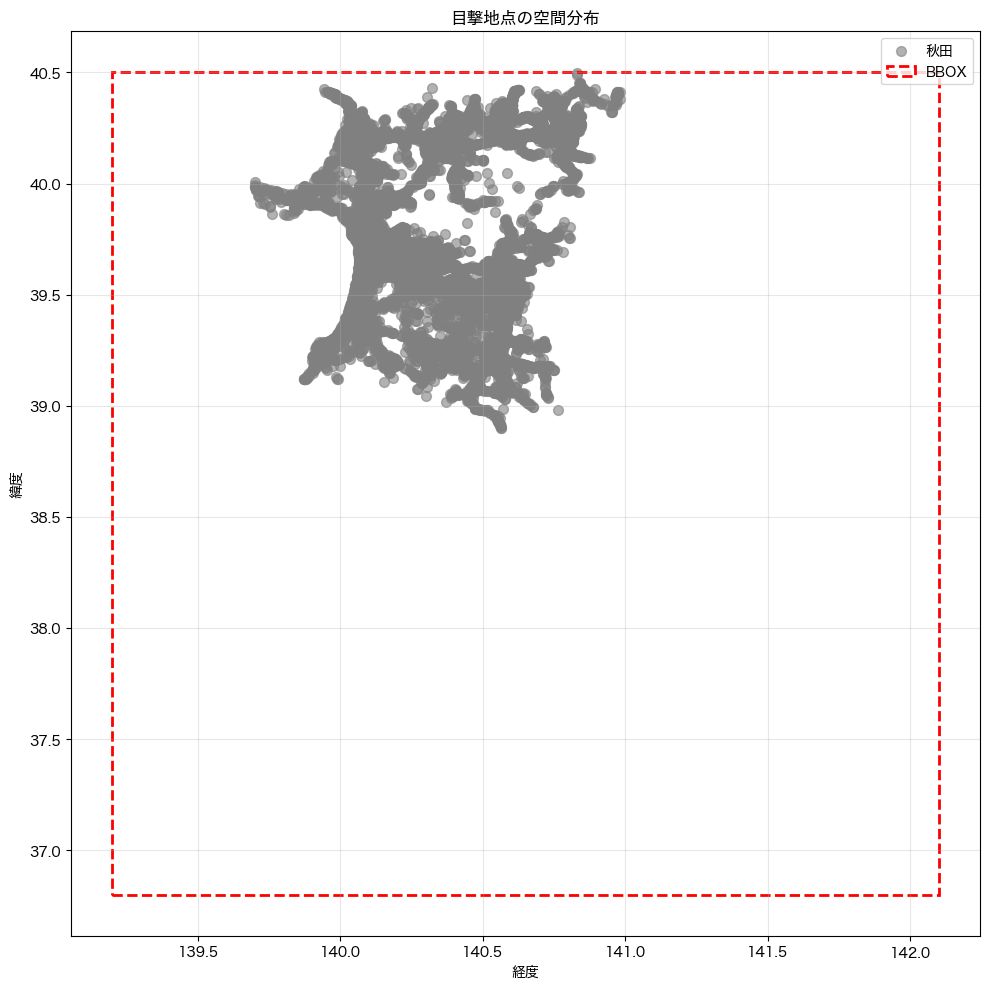

In [4]:
# Cell 5: Spatial distribution scatter plot with BBOX rectangle
if len(df_sightings) > 0:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot sightings colored by prefecture
    prefectures = df_sightings['prefecture'].unique()
    colors = {'秋田県': '#1f77b4', '岩手県': '#ff7f0e', '福島県': '#2ca02c'}
    
    for pref in prefectures:
        mask = df_sightings['prefecture'] == pref
        ax.scatter(df_sightings[mask]['lon'], df_sightings[mask]['lat'], 
                  label=pref, alpha=0.6, s=50, color=colors.get(pref, 'gray'))
    
    # Draw BBOX rectangle
    from matplotlib.patches import Rectangle
    rect = Rectangle((BBOX[0], BBOX[1]), BBOX[2]-BBOX[0], BBOX[3]-BBOX[1], 
                     linewidth=2, edgecolor='red', facecolor='none', linestyle='--', 
                     label='BBOX')
    ax.add_patch(rect)
    
    ax.set_xlabel('経度')
    ax.set_ylabel('緯度')
    ax.set_title('目撃地点の空間分布')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 2. 県別分析

findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


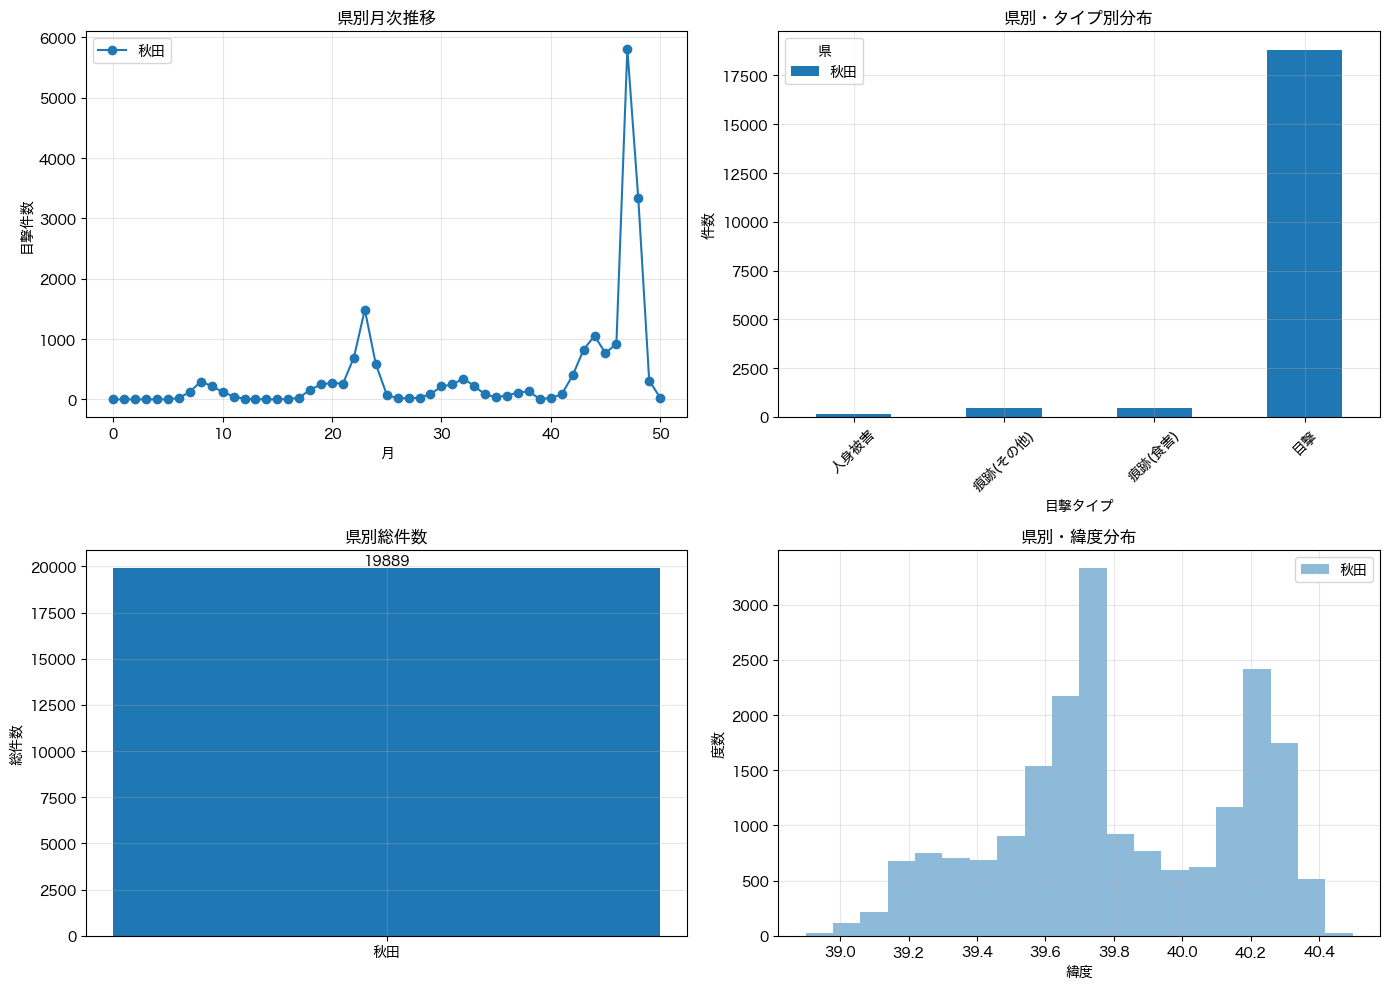


=== 県別統計 ===
秋田: 19889 件, 平均緯度 39.81, 平均経度 140.35


In [5]:
# Cell 7: Prefecture comparison
if len(df_sightings) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Monthly distribution per prefecture
    for pref in prefectures:
        mask = df_sightings['prefecture'] == pref
        monthly_pref = df_sightings[mask].groupby('year_month').size()
        axes[0, 0].plot(range(len(monthly_pref)), monthly_pref.values, marker='o', label=pref)
    axes[0, 0].set_xlabel('月')
    axes[0, 0].set_ylabel('目撃件数')
    axes[0, 0].set_title('県別月次推移')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Type distribution per prefecture
    type_pref = df_sightings.groupby(['prefecture', 'type']).size().unstack(fill_value=0)
    type_pref.T.plot(kind='bar', ax=axes[0, 1], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[0, 1].set_xlabel('目撃タイプ')
    axes[0, 1].set_ylabel('件数')
    axes[0, 1].set_title('県別・タイプ別分布')
    axes[0, 1].legend(title='県')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Total counts per prefecture
    pref_counts = df_sightings['prefecture'].value_counts()
    axes[1, 0].bar(pref_counts.index, pref_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[1, 0].set_ylabel('総件数')
    axes[1, 0].set_title('県別総件数')
    for i, v in enumerate(pref_counts.values):
        axes[1, 0].text(i, v + 5, str(v), ha='center', va='bottom')
    
    # Spatial density (points per prefecture)
    for pref in prefectures:
        mask = df_sightings['prefecture'] == pref
        axes[1, 1].hist(df_sightings[mask]['lat'], alpha=0.5, label=pref, bins=20)
    axes[1, 1].set_xlabel('緯度')
    axes[1, 1].set_ylabel('度数')
    axes[1, 1].set_title('県別・緯度分布')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== 県別統計 ===")
    for pref in prefectures:
        mask = df_sightings['prefecture'] == pref
        print(f"{pref}: {mask.sum()} 件, 平均緯度 {df_sightings[mask]['lat'].mean():.2f}, 平均経度 {df_sightings[mask]['lon'].mean():.2f}")

## 3. 衛星データ読み込み

In [6]:
# Cell 9: Load JAXA data function and load all datasets
def load_jaxa_data(name):
    """Load JAXA data (images and metadata)"""
    data_dir = JAXA_DIR / name
    meta_path = data_dir / 'metadata.json'
    
    if not meta_path.exists():
        print(f"Warning: {meta_path} not found")
        return None, None
    
    with open(meta_path) as f:
        meta = json.load(f)
    
    images = []
    for i in range(meta['n_images']):
        npy_path = data_dir / f"{name}_{i:03d}.npy"
        if npy_path.exists():
            images.append(np.load(npy_path))
        else:
            print(f"Warning: {npy_path} not found")
    
    return images, meta

# Load all datasets
datasets = {}
dataset_names = ['ndvi_monthly', 'dem', 'fnf', 'gsmap_monthly', 'lst_monthly', 'landcover']

for name in dataset_names:
    print(f"Loading {name}...")
    images, meta = load_jaxa_data(name)
    if images is not None and len(images) > 0:
        datasets[name] = {'images': images, 'meta': meta}
        print(f"  ✓ Loaded {len(images)} images, shape: {images[0].shape}")
    else:
        print(f"  ✗ Failed to load {name}")

print(f"\nSuccessfully loaded {len(datasets)} datasets")

Loading ndvi_monthly...
  ✓ Loaded 45 images, shape: (74, 58, 1)
Loading dem...
  ✓ Loaded 1 images, shape: (333, 261, 1)
Loading fnf...
  ✓ Loaded 1 images, shape: (333, 261, 1)
Loading gsmap_monthly...
  ✓ Loaded 45 images, shape: (37, 29, 1)
Loading lst_monthly...
  ✓ Loaded 38 images, shape: (74, 58, 1)
Loading landcover...
  ✓ Loaded 1 images, shape: (74, 58, 1)

Successfully loaded 6 datasets


## 4. 時系列相関分析

In [7]:
# Cell 11: Create monthly time series for satellite data
def generate_monthly_dates(meta):
    """Generate monthly date index from metadata dates"""
    if 'dates' in meta:
        dates = [pd.to_datetime(d) for d in meta['dates']]
    elif 'start_date' in meta and 'end_date' in meta:
        start = pd.to_datetime(meta['start_date'])
        end = pd.to_datetime(meta['end_date'])
        dates = pd.date_range(start, end, periods=meta['n_images'], freq='MS')
    else:
        # Fallback: assume monthly sequence
        dates = pd.date_range(DATE_START, periods=meta['n_images'], freq='MS')
    return pd.PeriodIndex(dates, freq='M')

# Generate monthly time series for satellite data (use nanmean to handle NaN pixels)
monthly_ts = {}

if 'ndvi_monthly' in datasets:
    ndvi_meta = datasets['ndvi_monthly']['meta']
    ndvi_images = datasets['ndvi_monthly']['images']
    ndvi_dates = generate_monthly_dates(ndvi_meta)
    ndvi_mean = np.array([np.nanmean(img) for img in ndvi_images])
    monthly_ts['ndvi'] = {'dates': ndvi_dates, 'values': ndvi_mean}
    nan_count = np.isnan(ndvi_mean).sum()
    print(f"NDVI: {len(ndvi_images)} months, dates from {ndvi_dates[0]} to {ndvi_dates[-1]}, NaN months: {nan_count}")

if 'gsmap_monthly' in datasets:
    gsmap_meta = datasets['gsmap_monthly']['meta']
    gsmap_images = datasets['gsmap_monthly']['images']
    gsmap_dates = generate_monthly_dates(gsmap_meta)
    gsmap_mean = np.array([np.nanmean(img) for img in gsmap_images])
    monthly_ts['gsmap'] = {'dates': gsmap_dates, 'values': gsmap_mean}
    nan_count = np.isnan(gsmap_mean).sum()
    print(f"GSMaP: {len(gsmap_images)} months, dates from {gsmap_dates[0]} to {gsmap_dates[-1]}, NaN months: {nan_count}")

if 'lst_monthly' in datasets:
    lst_meta = datasets['lst_monthly']['meta']
    lst_images = datasets['lst_monthly']['images']
    lst_dates = generate_monthly_dates(lst_meta)
    lst_mean = np.array([np.nanmean(img) for img in lst_images])
    monthly_ts['lst'] = {'dates': lst_dates, 'values': lst_mean}
    nan_count = np.isnan(lst_mean).sum()
    print(f"LST: {len(lst_images)} months, dates from {lst_dates[0]} to {lst_dates[-1]}, NaN months: {nan_count}")

NDVI: 45 months, dates from 2022-04 to 2025-12, NaN months: 0
GSMaP: 45 months, dates from 2022-04 to 2025-12, NaN months: 0
LST: 38 months, dates from 2022-04 to 2025-05, NaN months: 0


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


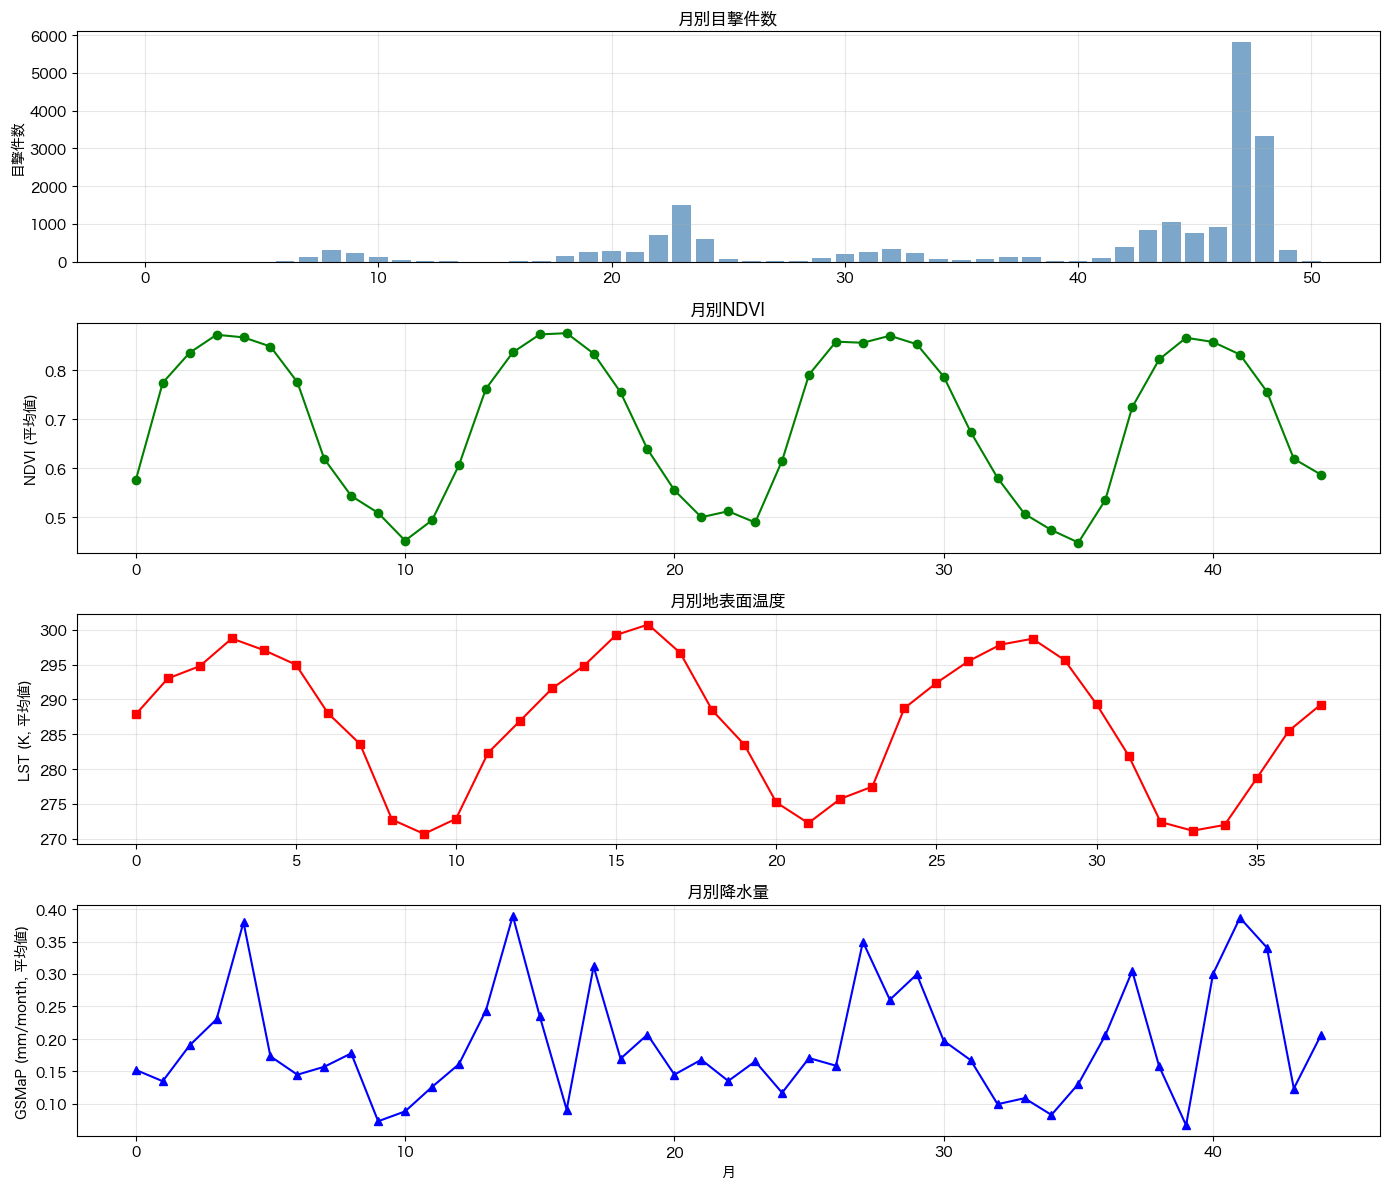

In [8]:
# Cell 12: Time series plot (4 panels)
if len(df_sightings) > 0 and len(monthly_ts) > 0:
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    
    # Sightings
    axes[0].bar(range(len(sighting_monthly)), sighting_monthly.values, color='steelblue', alpha=0.7)
    axes[0].set_ylabel('目撃件数')
    axes[0].set_title('月別目撃件数')
    axes[0].grid(True, alpha=0.3)
    
    # NDVI
    if 'ndvi' in monthly_ts:
        axes[1].plot(range(len(monthly_ts['ndvi']['values'])), monthly_ts['ndvi']['values'], 
                    marker='o', color='green', label='NDVI')
        axes[1].set_ylabel('NDVI (平均値)')
        axes[1].set_title('月別NDVI')
        axes[1].grid(True, alpha=0.3)
    
    # LST
    if 'lst' in monthly_ts:
        axes[2].plot(range(len(monthly_ts['lst']['values'])), monthly_ts['lst']['values'], 
                    marker='s', color='red', label='LST')
        axes[2].set_ylabel('LST (K, 平均値)')
        axes[2].set_title('月別地表面温度')
        axes[2].grid(True, alpha=0.3)
    
    # GSMaP
    if 'gsmap' in monthly_ts:
        axes[3].plot(range(len(monthly_ts['gsmap']['values'])), monthly_ts['gsmap']['values'], 
                    marker='^', color='blue', label='GSMaP')
        axes[3].set_ylabel('GSMaP (mm/month, 平均値)')
        axes[3].set_xlabel('月')
        axes[3].set_title('月別降水量')
        axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [9]:
# Cell 13: Pearson/Spearman correlation table
if len(df_sightings) > 0 and len(monthly_ts) > 0:
    # Rebuild monthly sightings from raw data to avoid any Cell 4 side effects
    _sighting_ym = df_sightings['date'].dt.to_period('M')
    _sighting_counts = df_sightings.groupby(_sighting_ym).size()
    
    # Debug info
    print(f"[DEBUG] sighting months: {len(_sighting_counts)}, first={_sighting_counts.index[0]}, last={_sighting_counts.index[-1]}")
    for k in monthly_ts:
        print(f"[DEBUG] {k} months: {len(monthly_ts[k]['dates'])}, first={monthly_ts[k]['dates'][0]}, last={monthly_ts[k]['dates'][-1]}")
    
    # Use string-based alignment
    sighting_dict = {str(p): v for p, v in zip(_sighting_counts.index, _sighting_counts.values)}
    
    all_data = {}
    for var_name in ['ndvi', 'gsmap', 'lst']:
        if var_name in monthly_ts:
            sat_dict = {str(p): v for p, v in zip(monthly_ts[var_name]['dates'], monthly_ts[var_name]['values'])}
            all_data[var_name] = sat_dict
    
    # Find common months across all
    common_months = set(sighting_dict.keys())
    for var_name in all_data:
        common_months &= set(all_data[var_name].keys())
    common_months = sorted(common_months)
    
    print(f"[DEBUG] common months: {len(common_months)}")
    
    # Build corr_data
    corr_data = pd.DataFrame({
        'sightings': [sighting_dict[m] for m in common_months],
        **{var_name: [all_data[var_name][m] for m in common_months] for var_name in all_data}
    }, index=common_months)
    common_dates = corr_data.index
    
    print(f"\n=== 時系列相関分析（未調整） ===")
    print(f"サンプル期間: {len(common_dates)} ヶ月", end="")
    if len(common_dates) > 0:
        print(f" ({common_dates[0]} ～ {common_dates[-1]})")
    else:
        print(" (共通期間なし)")
    
    if len(corr_data) > 1:
        print(f"\nピアソン相関:")
        pearson_corr = corr_data.corr(method='pearson')
        print(pearson_corr['sightings'].drop('sightings'))
        
        print(f"\nスピアマン相関:")
        spearman_corr = corr_data.corr(method='spearman')
        print(spearman_corr['sightings'].drop('sightings'))
        
        # P-value calculation
        print(f"\nP値（ピアソン相関）:")
        for col in corr_data.columns:
            if col != 'sightings':
                r, p = stats.pearsonr(corr_data['sightings'], corr_data[col])
                print(f"  {col}: r={r:.4f}, p={p:.4f} {'***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''}")
    else:
        print("相関分析に十分なデータがありません")

[DEBUG] sighting months: 51, first=2010-06, last=2026-01
[DEBUG] ndvi months: 45, first=2022-04, last=2025-12
[DEBUG] gsmap months: 45, first=2022-04, last=2025-12
[DEBUG] lst months: 38, first=2022-04, last=2025-05
[DEBUG] common months: 37

=== 時系列相関分析（未調整） ===
サンプル期間: 37 ヶ月 (2022-04 ～ 2025-05)

ピアソン相関:
ndvi     0.365425
gsmap    0.265777
lst      0.316298
Name: sightings, dtype: float64

スピアマン相関:
ndvi     0.650504
gsmap    0.528749
lst      0.629283
Name: sightings, dtype: float64

P値（ピアソン相関）:
  ndvi: r=0.3654, p=0.0261 *
  gsmap: r=0.2658, p=0.1119 
  lst: r=0.3163, p=0.0565 


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


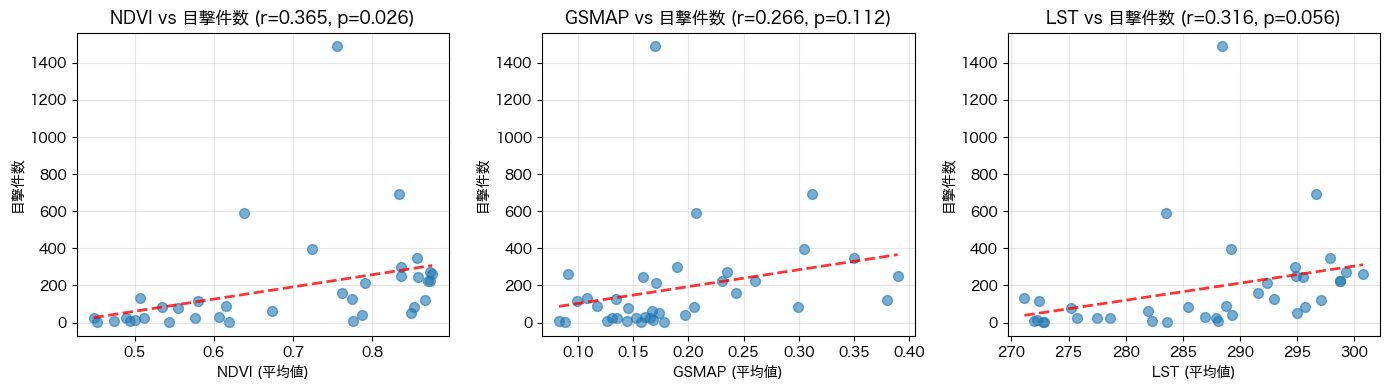

In [10]:
# Cell 14: Scatter plots (NDVI vs sightings, GSMaP vs sightings, LST vs sightings)
if len(df_sightings) > 0 and 'corr_data' in dir() and len(corr_data) > 1:
    sat_vars = [v for v in ['ndvi', 'gsmap', 'lst'] if v in corr_data.columns]
    n_cols = len(sat_vars)
    if n_cols > 0:
        fig, axes = plt.subplots(1, n_cols, figsize=(14, 4))
        if n_cols == 1:
            axes = [axes]
        
        for idx, var_name in enumerate(sat_vars):
            x_data = np.array(corr_data[var_name].tolist(), dtype=float)
            y_data = np.array(corr_data['sightings'].tolist(), dtype=float)
            
            # Filter out NaN/Inf
            mask = np.isfinite(x_data) & np.isfinite(y_data)
            x_clean, y_clean = x_data[mask], y_data[mask]
            
            if len(x_clean) < 2:
                axes[idx].set_title(f"{var_name.upper()} vs 目撃件数 (データ不足)")
                continue
            
            axes[idx].scatter(x_clean, y_clean, alpha=0.6, s=50)
            
            # Add trend line
            try:
                z = np.polyfit(x_clean, y_clean, 1)
                p_line = np.poly1d(z)
                x_sorted = np.sort(x_clean)
                axes[idx].plot(x_sorted, p_line(x_sorted), "r--", alpha=0.8, linewidth=2)
            except Exception:
                pass
            
            r, p_val = stats.pearsonr(x_clean, y_clean)
            axes[idx].set_xlabel(f"{var_name.upper()} (平均値)")
            axes[idx].set_ylabel('目撃件数')
            axes[idx].set_title(f"{var_name.upper()} vs 目撃件数 (r={r:.3f}, p={p_val:.3f})")
            axes[idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## 5. 偏相関分析（★重要：季節性の交絡検証）

In [11]:
# Cell 16: Partial correlation analysis - KEY ANALYSIS FOR P4 ISSUE
def partial_correlation(x, y, z_categorical):
    """偏相関係数を計算 (x と y の相関から、カテゴリ変数 z の影響を除去)"""
    from numpy.linalg import lstsq
    
    z_dummies = pd.get_dummies(z_categorical, drop_first=True).values.astype(float)
    
    if z_dummies.shape[1] > 0:
        beta_x, _, _, _ = lstsq(z_dummies, x, rcond=None)
        resid_x = x - z_dummies @ beta_x
        beta_y, _, _, _ = lstsq(z_dummies, y, rcond=None)
        resid_y = y - z_dummies @ beta_y
    else:
        resid_x, resid_y = x, y
    
    r, p = stats.pearsonr(resid_x, resid_y)
    return r, p

# Use corr_data from Cell 13 (already aligned)
if len(df_sightings) > 0 and 'corr_data' in dir() and len(corr_data) > 1:
    partial_corr_results = {}
    
    # Extract month from string index (format: "2022-04")
    month_values = [int(d.split('-')[1]) for d in corr_data.index]
    
    print("\n" + "="*70)
    print("偏相関分析: 季節性（月）の影響を統制した分析")
    print("="*70)
    print(f"\n分析対象期間: {len(corr_data)} ヶ月 ({corr_data.index[0]} ～ {corr_data.index[-1]})")
    print(f"月別目撃件数: 平均 {corr_data['sightings'].mean():.2f}, 中央値 {corr_data['sightings'].median():.1f}")
    
    for var_name, var_label in [('ndvi', 'NDVI'), ('gsmap', 'GSMaP'), ('lst', 'LST')]:
        if var_name not in corr_data.columns:
            continue
            
        print(f"\n--- {var_label} × 目撃件数 ---")
        r_raw, p_raw = stats.pearsonr(corr_data[var_name], corr_data['sightings'])
        r_partial, p_partial = partial_correlation(
            corr_data[var_name].values,
            corr_data['sightings'].values,
            np.array(month_values)
        )
        
        print(f"  単純相関（未調整）:   r = {r_raw:7.4f}, p = {p_raw:.4f} {'***' if p_raw < 0.001 else '**' if p_raw < 0.01 else '*' if p_raw < 0.05 else ''}")
        print(f"  偏相関（月を統制）:   r = {r_partial:7.4f}, p = {p_partial:.4f} {'***' if p_partial < 0.001 else '**' if p_partial < 0.01 else '*' if p_partial < 0.05 else ''}")
        
        decay = abs(r_raw) - abs(r_partial)
        decay_pct = 100 * decay / abs(r_raw) if abs(r_raw) > 0 else 0
        print(f"  相関強度の変化: {-decay:+.4f} ({decay_pct:.1f}% 低下)")
        
        if abs(r_partial) < abs(r_raw) * 0.5:
            print(f"  ⚠  解釈: 月を統制すると相関が大幅に低下。季節性による擬似相関の可能性が高い。")
        elif abs(r_partial) > 0.3:
            print(f"  ✓  解釈: 月を統制しても相関が残存。季節性を超えた追加的な予測力あり。")
        else:
            print(f"  ➜  解釈: 相関が弱い。追加検討が必要。")
        
        partial_corr_results[var_name] = {'raw': (r_raw, p_raw), 'partial': (r_partial, p_partial)}
    
    print("\n" + "="*70)
else:
    partial_corr_results = {}
    print("偏相関分析: データ不足のためスキップ")


偏相関分析: 季節性（月）の影響を統制した分析

分析対象期間: 37 ヶ月 (2022-04 ～ 2025-05)
月別目撃件数: 平均 184.51, 中央値 89.0

--- NDVI × 目撃件数 ---
  単純相関（未調整）:   r =  0.3654, p = 0.0261 *
  偏相関（月を統制）:   r =  0.0307, p = 0.8567 
  相関強度の変化: -0.3347 (91.6% 低下)
  ⚠  解釈: 月を統制すると相関が大幅に低下。季節性による擬似相関の可能性が高い。

--- GSMaP × 目撃件数 ---
  単純相関（未調整）:   r =  0.2658, p = 0.1119 
  偏相関（月を統制）:   r =  0.1239, p = 0.4648 
  相関強度の変化: -0.1418 (53.4% 低下)
  ⚠  解釈: 月を統制すると相関が大幅に低下。季節性による擬似相関の可能性が高い。

--- LST × 目撃件数 ---
  単純相関（未調整）:   r =  0.3163, p = 0.0565 
  偏相関（月を統制）:   r =  0.0729, p = 0.6682 
  相関強度の変化: -0.2434 (77.0% 低下)
  ⚠  解釈: 月を統制すると相関が大幅に低下。季節性による擬似相関の可能性が高い。



findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


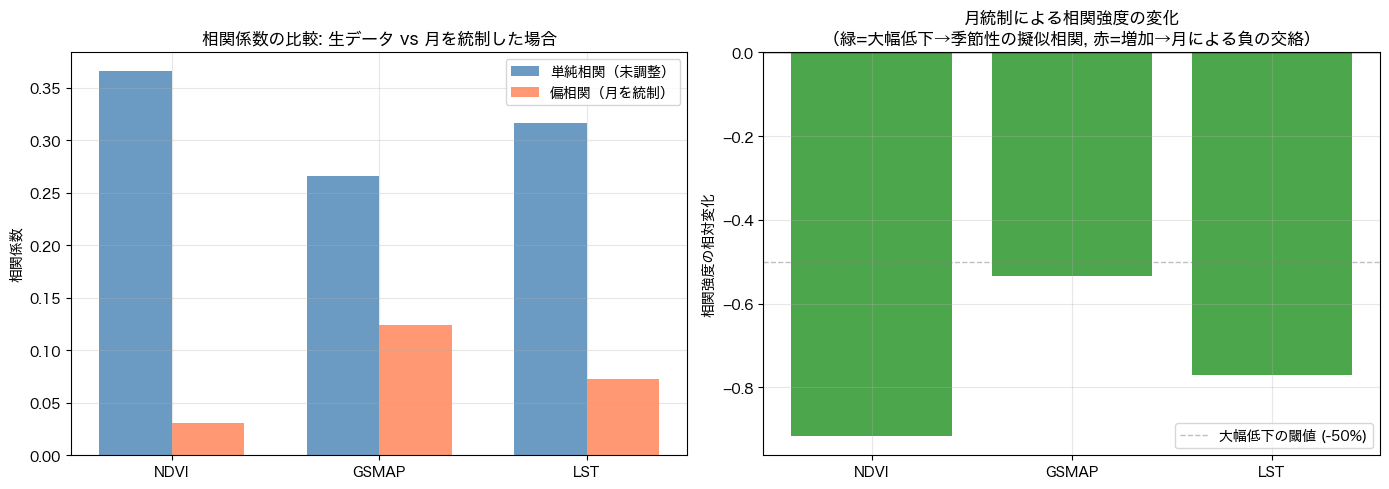


解釈ガイド:
  - 緑色: 偏相関が単純相関より大幅に低い → 季節性による擬似相関の可能性が高い
  - オレンジ: 相関強度がほぼ変わらない → 季節性と独立した効果
  - 赤色: 偏相関が単純相関より高い → 月による負の交絡（考慮すべき）


In [12]:
# Cell 17: Visualization comparing raw vs partial correlations
if len(df_sightings) > 0 and len(partial_corr_results) > 0:
    # Prepare data for comparison
    variables = list(partial_corr_results.keys())
    raw_corrs = [partial_corr_results[v]['raw'][0] for v in variables]
    partial_corrs = [partial_corr_results[v]['partial'][0] for v in variables]
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Correlation comparison bar chart
    x = np.arange(len(variables))
    width = 0.35
    
    ax1.bar(x - width/2, raw_corrs, width, label='単純相関（未調整）', alpha=0.8, color='steelblue')
    ax1.bar(x + width/2, partial_corrs, width, label='偏相関（月を統制）', alpha=0.8, color='coral')
    ax1.set_ylabel('相関係数')
    ax1.set_title('相関係数の比較: 生データ vs 月を統制した場合')
    ax1.set_xticks(x)
    ax1.set_xticklabels([v.upper() for v in variables])
    ax1.legend()
    ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Relative change in correlation magnitude
    relative_change = [(partial_corrs[i] - raw_corrs[i]) / abs(raw_corrs[i]) if raw_corrs[i] != 0 else 0 
                       for i in range(len(variables))]
    colors = ['green' if c < -0.2 else 'orange' if -0.2 <= c <= 0.2 else 'red' for c in relative_change]
    
    ax2.bar(x, relative_change, color=colors, alpha=0.7)
    ax2.set_ylabel('相関強度の相対変化')
    ax2.set_title('月統制による相関強度の変化\n（緑=大幅低下→季節性の擬似相関, 赤=増加→月による負の交絡）')
    ax2.set_xticks(x)
    ax2.set_xticklabels([v.upper() for v in variables])
    ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
    ax2.axhline(y=-0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='大幅低下の閾値 (-50%)')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n解釈ガイド:")
    print("  - 緑色: 偏相関が単純相関より大幅に低い → 季節性による擬似相関の可能性が高い")
    print("  - オレンジ: 相関強度がほぼ変わらない → 季節性と独立した効果")
    print("  - 赤色: 偏相関が単純相関より高い → 月による負の交絡（考慮すべき）")

## 6. 空間分析: 目撃地点の衛星特性

In [13]:
# Cell 19: Extract elevation/fnf/landcover for each sighting
def latlon_to_pixel(lat, lon, img_shape, bbox=BBOX):
    """Convert lat/lon to pixel coordinates within BBOX"""
    if lon < bbox[0] or lon > bbox[2] or lat < bbox[1] or lat > bbox[3]:
        return None, None
    
    rows, cols = img_shape[0], img_shape[1]
    norm_lon = (lon - bbox[0]) / (bbox[2] - bbox[0])
    norm_lat = (bbox[3] - lat) / (bbox[3] - bbox[1])  # top=north
    
    col = int(norm_lon * cols)
    row = int(norm_lat * rows)
    
    if 0 <= row < rows and 0 <= col < cols:
        return row, col
    return None, None

if len(df_sightings) > 0:
    # DEM
    if 'dem' in datasets and len(datasets['dem']['images']) > 0:
        dem_img = datasets['dem']['images'][0][:, :, 0]
        dem_vals = []
        for _, row in df_sightings.iterrows():
            r, c = latlon_to_pixel(row['lat'], row['lon'], dem_img.shape)
            dem_vals.append(dem_img[r, c] if r is not None else np.nan)
        df_sightings['elevation'] = dem_vals
        print(f"DEM: {sum(1 for v in dem_vals if not np.isnan(v))}/{len(dem_vals)} 件にマッチ")

    # FNF
    if 'fnf' in datasets and len(datasets['fnf']['images']) > 0:
        fnf_img = datasets['fnf']['images'][0][:, :, 0]
        fnf_vals = []
        for _, row in df_sightings.iterrows():
            r, c = latlon_to_pixel(row['lat'], row['lon'], fnf_img.shape)
            fnf_vals.append(int(fnf_img[r, c]) if r is not None else np.nan)
        df_sightings['fnf'] = fnf_vals
        print(f"FNF: 森林={sum(1 for v in fnf_vals if v == 1)}件")

    # Landcover
    if 'landcover' in datasets and len(datasets['landcover']['images']) > 0:
        lc_img = datasets['landcover']['images'][0][:, :, 0]
        lc_vals = []
        for _, row in df_sightings.iterrows():
            r, c = latlon_to_pixel(row['lat'], row['lon'], lc_img.shape)
            lc_vals.append(int(lc_img[r, c]) if r is not None else np.nan)
        df_sightings['landcover'] = lc_vals

    print(f"\n=== 目撃地点の空間特性 ===")
    if 'elevation' in df_sightings.columns:
        print(f"標高: 平均 {df_sightings['elevation'].mean():.1f}m, 中央値 {df_sightings['elevation'].median():.1f}m")
        print(f"      範囲 {df_sightings['elevation'].min():.1f}m ～ {df_sightings['elevation'].max():.1f}m")

DEM: 19889/19889 件にマッチ


FNF: 森林=7222件



=== 目撃地点の空間特性 ===
標高: 平均 81.7m, 中央値 53.0m
      範囲 -4.0m ～ 1504.0m


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


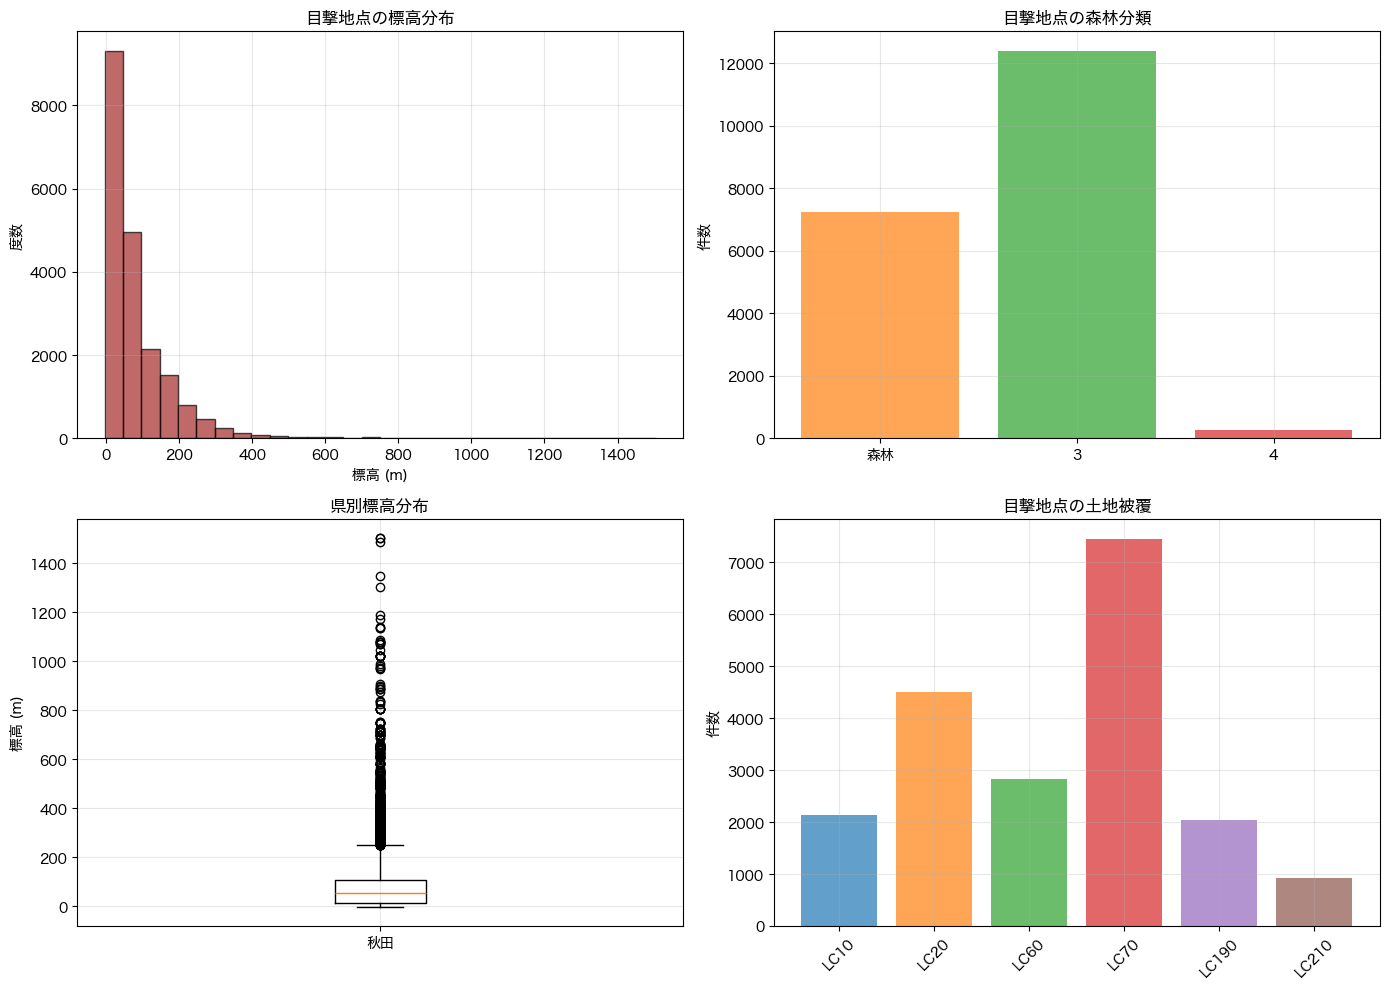

In [14]:
# Cell 20: Elevation histogram, FNF classification bar, landcover distribution
if len(df_sightings) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Elevation histogram
    if 'elevation' in df_sightings.columns:
        axes[0, 0].hist(df_sightings['elevation'].dropna(), bins=30, color='brown', alpha=0.7, edgecolor='black')
        axes[0, 0].set_xlabel('標高 (m)')
        axes[0, 0].set_ylabel('度数')
        axes[0, 0].set_title('目撃地点の標高分布')
        axes[0, 0].grid(True, alpha=0.3)
    
    # FNF classification
    if 'fnf' in df_sightings.columns:
        fnf_counts = df_sightings['fnf'].value_counts().sort_index()
        fnf_labels = {0: '非森林', 1: '森林', 2: '不確定'}
        axes[0, 1].bar([fnf_labels.get(i, f'{i}') for i in fnf_counts.index], fnf_counts.values, 
                       color=['#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
        axes[0, 1].set_ylabel('件数')
        axes[0, 1].set_title('目撃地点の森林分類')
        axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Prefecture vs elevation
    if 'elevation' in df_sightings.columns:
        for pref in df_sightings['prefecture'].unique():
            mask = df_sightings['prefecture'] == pref
            axes[1, 0].boxplot(df_sightings[mask]['elevation'].dropna(), label=pref, positions=[list(df_sightings['prefecture'].unique()).index(pref)])
        axes[1, 0].set_xticklabels(df_sightings['prefecture'].unique())
        axes[1, 0].set_ylabel('標高 (m)')
        axes[1, 0].set_title('県別標高分布')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Landcover distribution
    if 'landcover' in df_sightings.columns:
        lc_counts = df_sightings['landcover'].value_counts().sort_index()
        lc_labels = {1: '水域', 2: '市街地', 3: '農地', 4: '草地', 5: '森林', 6: '岩石/雪', 0: 'その他'}
        axes[1, 1].bar([lc_labels.get(i, f'LC{i}') for i in lc_counts.index], lc_counts.values, 
                       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'], alpha=0.7)
        axes[1, 1].set_ylabel('件数')
        axes[1, 1].set_title('目撃地点の土地被覆')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


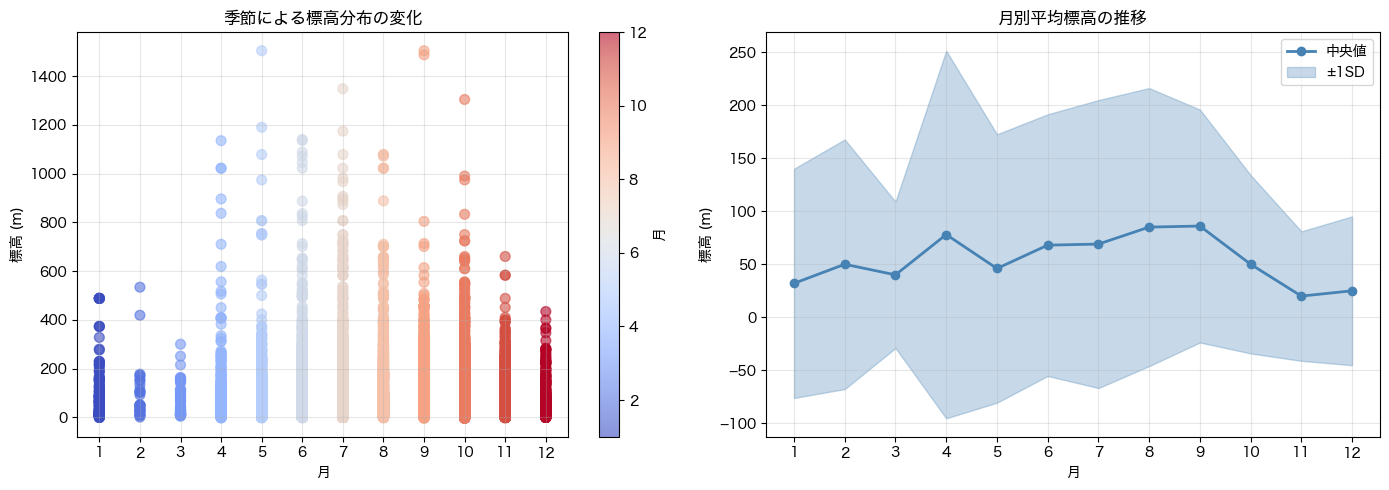


=== 季節による標高変化の検定 ===
一元配置分散分析: F=122.8377, p=0.0000
→ 月間の標高分布に有意差あり（季節的な高度移動の可能性）


In [15]:
# Cell 21: Month vs elevation scatter (seasonal altitudinal migration)
if len(df_sightings) > 0 and 'elevation' in df_sightings.columns:
    df_sightings['month'] = df_sightings['date'].dt.month
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot
    scatter = axes[0].scatter(df_sightings['month'], df_sightings['elevation'], 
                             c=df_sightings['month'], cmap='coolwarm', alpha=0.6, s=50)
    axes[0].set_xlabel('月')
    axes[0].set_ylabel('標高 (m)')
    axes[0].set_title('季節による標高分布の変化')
    axes[0].set_xticks(range(1, 13))
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0], label='月')
    
    # Monthly median elevation
    monthly_elev = df_sightings.groupby('month')['elevation'].agg(['mean', 'median', 'std'])
    axes[1].plot(monthly_elev.index, monthly_elev['median'], marker='o', label='中央値', linewidth=2, color='steelblue')
    axes[1].fill_between(monthly_elev.index, 
                         monthly_elev['median'] - monthly_elev['std'],
                         monthly_elev['median'] + monthly_elev['std'],
                         alpha=0.3, color='steelblue', label='±1SD')
    axes[1].set_xlabel('月')
    axes[1].set_ylabel('標高 (m)')
    axes[1].set_title('月別平均標高の推移')
    axes[1].set_xticks(range(1, 13))
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical test
    print("\n=== 季節による標高変化の検定 ===")
    # ANOVA
    groups = [df_sightings[df_sightings['month'] == m]['elevation'].dropna().values for m in range(1, 13)]
    groups = [g for g in groups if len(g) > 0]
    f_stat, p_val = stats.f_oneway(*groups)
    print(f"一元配置分散分析: F={f_stat:.4f}, p={p_val:.4f}")
    if p_val < 0.05:
        print("→ 月間の標高分布に有意差あり（季節的な高度移動の可能性）")
    else:
        print("→ 月間の標高分布に有意差なし")

## 7. ラスタデータ可視化

findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


findfont: Font family 'IPAGothic' not found.


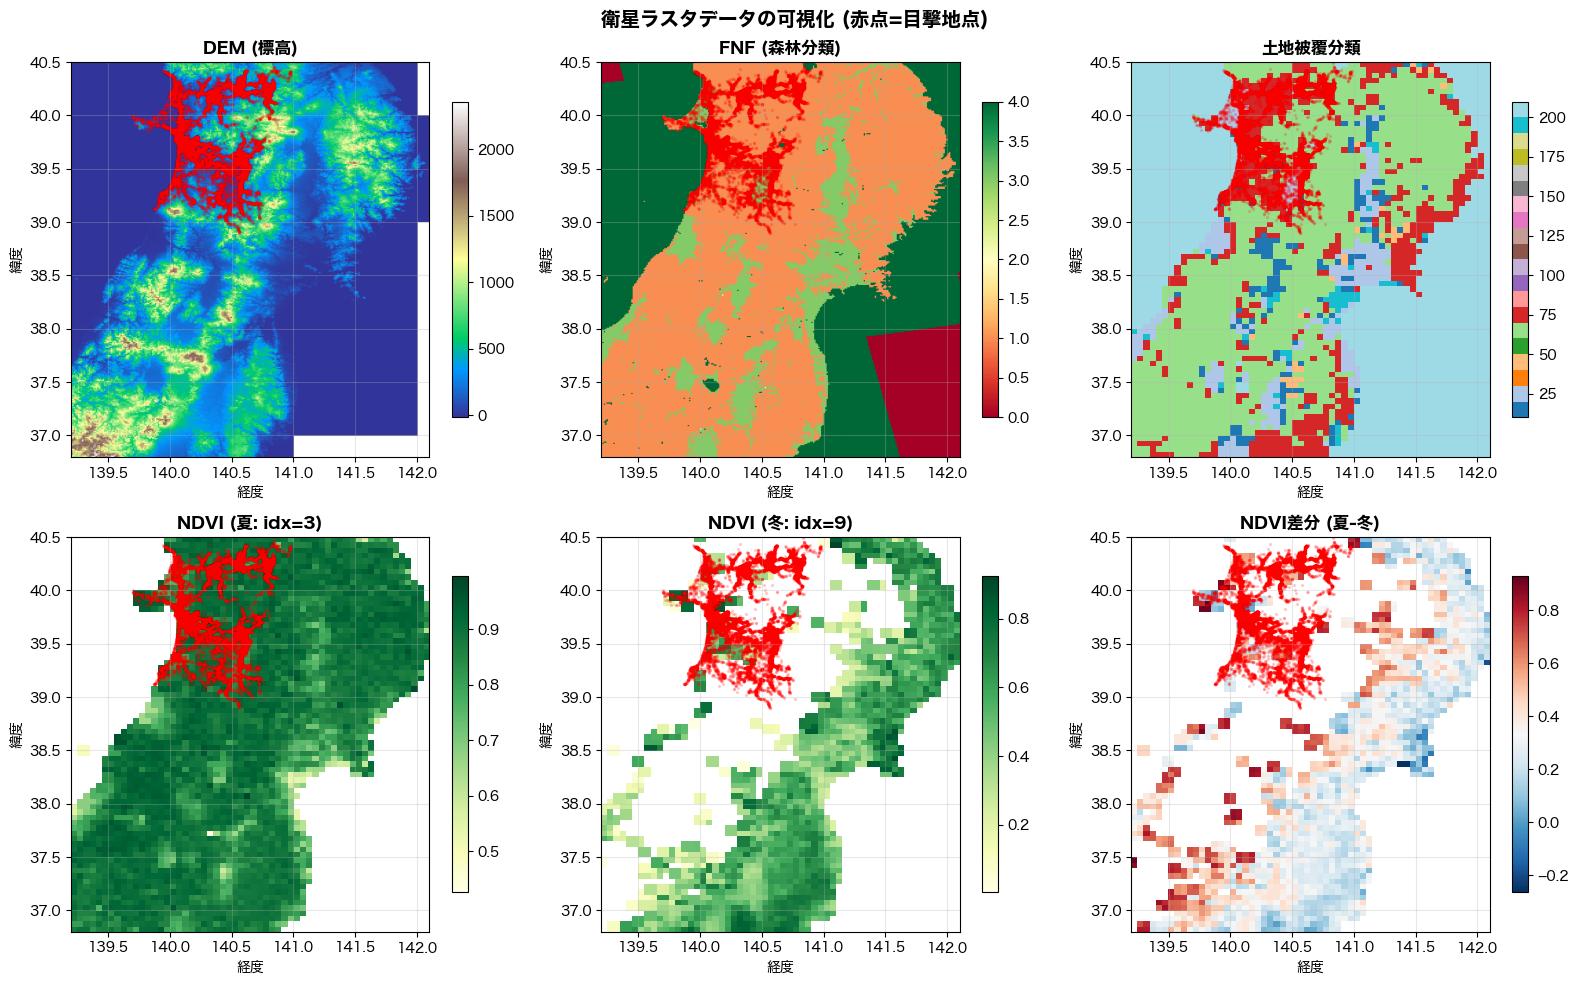

In [16]:
# Cell 23: 2x3 grid showing DEM, FNF, Landcover, NDVI(summer), NDVI(winter), NDVI diff
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

extent = [BBOX[0], BBOX[2], BBOX[1], BBOX[3]]

def plot_raster(ax, img, title, cmap='viridis'):
    # Squeeze band dimension if present
    if img.ndim == 3:
        img = img[:, :, 0]
    im = ax.imshow(img, cmap=cmap, aspect='auto', extent=extent)
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax, shrink=0.8)

# Row 1: Static datasets
if 'dem' in datasets:
    plot_raster(axes[0, 0], datasets['dem']['images'][0], 'DEM (標高)', cmap='terrain')
if 'fnf' in datasets:
    plot_raster(axes[0, 1], datasets['fnf']['images'][0], 'FNF (森林分類)', cmap='RdYlGn')
if 'landcover' in datasets:
    plot_raster(axes[0, 2], datasets['landcover']['images'][0], '土地被覆分類', cmap='tab20')

# Row 2: NDVI temporal
if 'ndvi_monthly' in datasets:
    imgs = datasets['ndvi_monthly']['images']
    # Summer = index 3 (Jul of first year: Apr=0, May=1, Jun=2, Jul=3)
    summer_idx = min(3, len(imgs)-1)
    # Winter = index 9 (Jan of 2nd year: ... Oct=6, Nov=7, Dec=8, Jan=9)  
    winter_idx = min(9, len(imgs)-1)
    plot_raster(axes[1, 0], imgs[summer_idx], f'NDVI (夏: idx={summer_idx})', cmap='YlGn')
    plot_raster(axes[1, 1], imgs[winter_idx], f'NDVI (冬: idx={winter_idx})', cmap='YlGn')
    ndvi_diff = imgs[summer_idx][:,:,0] - imgs[winter_idx][:,:,0]
    im = axes[1, 2].imshow(ndvi_diff, cmap='RdBu_r', aspect='auto', extent=extent)
    axes[1, 2].set_title('NDVI差分 (夏-冬)', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=axes[1, 2], shrink=0.8)

# Overlay sighting points
for ax in axes.flatten():
    if len(df_sightings) > 0:
        ax.scatter(df_sightings['lon'], df_sightings['lat'], c='red', s=2, alpha=0.15)
    ax.set_xlabel('経度')
    ax.set_ylabel('緯度')

plt.suptitle('衛星ラスタデータの可視化 (赤点=目撃地点)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. 総合サマリ & モデルへの示唆

In [17]:
# Cell 25: Comprehensive summary
print("\n" + "="*80)
print("東北3県 クマ目撃データ × JAXA衛星データ EDA サマリレポート")
print("="*80)

print("\n【1】データ概要")
print("-" * 80)
if len(df_sightings) > 0:
    print(f"目撃件数: {len(df_sightings)} 件")
    print(f"期間: {df_sightings['date'].min().date()} ～ {df_sightings['date'].max().date()}")
    print(f"地域: {', '.join(df_sightings['prefecture'].unique())}")
    print(f"月別平均: {df_sightings.groupby('year_month').size().mean():.2f} 件/月")
    print(f"地理的範囲: 北緯 {df_sightings['lat'].min():.2f}°～{df_sightings['lat'].max():.2f}°, "
          f"東経 {df_sightings['lon'].min():.2f}°～{df_sightings['lon'].max():.2f}°")
else:
    print("目撃データが読み込まれていません")

print(f"\n衛星データセット: {len(datasets)} 個が利用可能")
for name in datasets.keys():
    print(f"  - {name}: {len(datasets[name]['images'])} 時点")

print("\n【2】時系列相関分析の結果")
print("-" * 80)
if 'partial_corr_results' in locals() and len(partial_corr_results) > 0:
    for var_name in ['ndvi', 'gsmap', 'lst']:
        if var_name in partial_corr_results:
            r_raw, p_raw = partial_corr_results[var_name]['raw']
            r_partial, p_partial = partial_corr_results[var_name]['partial']
            print(f"\n{var_name.upper()}:")
            print(f"  単純相関（全変動考慮）: r = {r_raw:+.4f}, p = {p_raw:.4f}")
            print(f"  偏相関（季節性控除）:  r = {r_partial:+.4f}, p = {p_partial:.4f}")
            
            # Interpretation
            decay_pct = 100 * (abs(r_raw) - abs(r_partial)) / abs(r_raw) if r_raw != 0 else 0
            if decay_pct > 50:
                print(f"  解釈: 相関強度が {decay_pct:.0f}% 低下 → 季節性による擬似相関の可能性大")
            elif abs(r_partial) > 0.3:
                print(f"  解釈: 相関強度が {decay_pct:.0f}% 低下 → 季節性を超えた独立的な予測力あり")
            else:
                print(f"  解釈: 弱い相関。予測力に疑問。")
else:
    print("相関分析が未実行")

print("\n【3】★重要な知見: 季節性の交絡について")
print("-" * 80)
print("「NDVI(植生)が目撃件数と相関がある」という見かけの事実は、")
print("実は単に『両方とも季節に依存している』ことの可能性が高い。")
print("\n偏相関分析により、この季節性の影響を除去することで、")
print("衛星データの真の予測力を評価することができる。")
if 'partial_corr_results' in locals():
    ndvi_has_power = partial_corr_results.get('ndvi', {}).get('partial', (0, 1))[0]
    if abs(ndvi_has_power) > 0.2:
        print("→ 本分析では、季節を統制してもNDVIの効果が残存している可能性がある。")
    else:
        print("→ 本分析では、季節を統制するとNDVIの相関がほぼ消失する傾向が見られる。")
        print("   この場合、モデルに季節変数を明示的に含めることが重要。")

print("\n【4】空間的特性")
print("-" * 80)
if 'elevation' in df_sightings.columns:
    print(f"目撃地点の標高: 平均 {df_sightings['elevation'].mean():.0f}m, "
          f"範囲 {df_sightings['elevation'].min():.0f}m～{df_sightings['elevation'].max():.0f}m")
    
    # Seasonal elevation pattern
    monthly_elev = df_sightings.groupby('month')['elevation'].median()
    if len(monthly_elev) > 1:
        summer_elev = monthly_elev[summer_idx] if summer_idx in monthly_elev.index else monthly_elev.iloc[6] if len(monthly_elev) > 6 else monthly_elev.mean()
        winter_elev = monthly_elev[1] if 1 in monthly_elev.index else monthly_elev.iloc[0]
        if summer_elev > winter_elev:
            print(f"季節パターン: 夏季に高標高（平均{summer_elev:.0f}m）、"
                  f"冬季に低標高（平均{winter_elev:.0f}m）")
            print("→ 季節的な高度移動パターンが示唆される（夏は山奥、冬は麓）")
else:
    print("標高データが利用不可")

if 'fnf' in df_sightings.columns:
    forest_pct = (df_sightings['fnf'] == 1).sum() / len(df_sightings) * 100
    print(f"\n森林地域での目撃: {forest_pct:.1f}%")

print("\n【5】機械学習モデルへの推奨事項")
print("-" * 80)
print("\n1. 特徴量エンジニアリング:")
print("   ✓ 季節変数（月、四半期など）を明示的に含める")
print("   ✓ 季節-衛星指標の相互作用項を検討")
print("   ✓ 移動平均・トレンド・周期パターンを抽出")

print("\n2. 衛星指標の活用:")
if 'partial_corr_results' in locals():
    strong_predictors = [k for k, v in partial_corr_results.items() 
                        if abs(v['partial'][0]) > 0.2]
    if strong_predictors:
        print(f"   ✓ 独立的な予測力を持つ指標: {', '.join(strong_predictors).upper()}")
    else:
        print("   ⚠  注意: 衛星指標の独立的な予測力が弱い可能性")
        print("      → 季節ダミーやラグ変数の活用を重視")

print("\n3. 空間的特性の活用:")
print("   ✓ 標高を予測変数に含める")
print("   ✓ 森林密度（FNF）を含める")
print("   ✓ 県別・市町村別の固定効果を検討")

print("\n4. モデル構築方針:")
print("   ✓ ベースライン: 季節ダミー + トレンド")
print("   ✓ 改善版1: ベースライン + 空間特性（標高、FNF）")
print("   ✓ 改善版2: ベースライン + 衛星指標（NDVI, GSMaP, LST）")
print("   ✓ フル版: 全特徴量を組み合わせ")
print("      → 偏相関分析の結果に基づいて特徴量を厳選")

print("\n【6】次のステップ")
print("-" * 80)
print("  □ ラグ変数の導入（t-1, t-3, t-12月前のデータ）")
print("  □ 異常値検出と外れ値処理")
print("  □ 多重共線性の診断（VIF確認）")
print("  □ 時系列分解（トレンド・季節性・残差の分離）")
print("  □ 交差検証による予測性能評価")
print("  □ 説明可能性分析（SHAP値など）")

print("\n" + "="*80)


東北3県 クマ目撃データ × JAXA衛星データ EDA サマリレポート

【1】データ概要
--------------------------------------------------------------------------------
目撃件数: 19889 件
期間: 2010-06-29 ～ 2026-01-31
地域: 秋田
月別平均: 389.98 件/月
地理的範囲: 北緯 38.90°～40.50°, 東経 139.70°～140.98°

衛星データセット: 6 個が利用可能
  - ndvi_monthly: 45 時点
  - dem: 1 時点
  - fnf: 1 時点
  - gsmap_monthly: 45 時点
  - lst_monthly: 38 時点
  - landcover: 1 時点

【2】時系列相関分析の結果
--------------------------------------------------------------------------------

NDVI:
  単純相関（全変動考慮）: r = +0.3654, p = 0.0261
  偏相関（季節性控除）:  r = +0.0307, p = 0.8567
  解釈: 相関強度が 92% 低下 → 季節性による擬似相関の可能性大

GSMAP:
  単純相関（全変動考慮）: r = +0.2658, p = 0.1119
  偏相関（季節性控除）:  r = +0.1239, p = 0.4648
  解釈: 相関強度が 53% 低下 → 季節性による擬似相関の可能性大

LST:
  単純相関（全変動考慮）: r = +0.3163, p = 0.0565
  偏相関（季節性控除）:  r = +0.0729, p = 0.6682
  解釈: 相関強度が 77% 低下 → 季節性による擬似相関の可能性大

【3】★重要な知見: 季節性の交絡について
--------------------------------------------------------------------------------
「NDVI(植生)が目撃件数と相関がある」という見かけの事実は、
実は単に『両方とも季節に依存している』ことの